In [9]:
from Games.CoopEnv_ep import CoopEnv
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [10]:
n = 10
tasks = 5
percentage = 0.2
env = CoopEnv(n=n, task_num=tasks,percentage=percentage)
action_size = env.num_of_tasks

In [11]:
class ActorNetwork(tf.keras.Model):
    
    def __init__(self):
        
        super().__init__()
        # Shared layers for policy and value function networks
        self.layer1 = tf.keras.layers.Dense(256, activation = 'relu')
        self.layer2 = tf.keras.layers.Dense(256, activation = 'relu')
        self.pout = tf.keras.layers.Dense(action_size, activation = 'softmax') # state to action probabilities 
        
    def call(self, state):
        
        x = tf.convert_to_tensor(state)
        x = self.layer1(x)
        x = self.layer2(x)
        probs = self.pout(x)
        
        return probs

In [12]:
class CriticNetwork(tf.keras.Model):
    
    def __init__(self):
        
        super().__init__()
        # Shared layers for policy and value function networks
        self.layer1 = tf.keras.layers.Dense(256, activation = 'relu')
        self.layer2 = tf.keras.layers.Dense(256, activation = 'relu')
        self.vout = tf.keras.layers.Dense(1, activation = None) # ... from state to value scalar
        
    def call(self, state):
        
        x = tf.convert_to_tensor(state)
        x = self.layer1(x)
        x = self.layer2(x)
        value = self.vout(x)
        
        return value


In [13]:
class Agent():
    
    def __init__(self):
        self.aModel = ActorNetwork()
        self.vModel = CriticNetwork()
        self.gamma = 0.99
        self.alr = 1e-4
        self.clr = 1e-4
        self.aopt = tf.keras.optimizers.Adam(learning_rate=self.alr)
        self.copt = tf.keras.optimizers.Adam(learning_rate=self.clr)
        
    def choose_action(self, state):
        a_probs = self.aModel(np.array([state]))
        dist = tfp.distributions.Categorical(probs = a_probs, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
    
    def calculate_loss(self, a_probs, action, delta):
        dist = tfp.distributions.Categorical(probs = a_probs, dtype=tf.float32)
        log_prob = dist.log_prob(action) # get log(pi(a\s))
        return -log_prob*delta
    
    def train(self, state, action, reward, next_state, terminated): # train from an episode of experience
        
        state = np.array([state])
        next_state = np.array([next_state])
        
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
            a =  self.aModel(state,training=True) # action probabilities and value of state S_t
            v = self.vModel(state, training=True) # action probabilities and value of state S_t+1
            v_p = self.vModel(next_state, training=True)
            td = reward + self.gamma*v_p - v # calculate TD error
            
            a_update = self.calculate_loss(a, action, td)
            c_update = td**2
        
        grads1 = tape1.gradient(a_update, self.aModel.trainable_variables)
        grads2 = tape2.gradient(c_update, self.vModel.trainable_variables)
        self.aopt.apply_gradients(zip(grads1, self.aModel.trainable_variables))
        self.copt.apply_gradients(zip(grads2, self.vModel.trainable_variables))
        
        return a_update, c_update


In [14]:
num_of_sims = 1
num_of_episodes = 1000
steps_to_complete = np.zeros((num_of_sims, num_of_episodes))

In [15]:
def main():
    
    for s in range(num_of_sims):
        
        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")
        
        # reinitialise agent list each sim
        agentlist = {}
        for agent in range(env.n):
            agentlist[agent] = Agent() # instantiate an Agent() class for each player

        for e in range(num_of_episodes):

            observations = env.reset(n=n, task_num=tasks, percentage=percentage)
            tstp = 0

            while env.done==False:
                
                actions = [agentlist[agent].choose_action(observations[agent]) for agent in range(env.n)]

                next_observations, rewards, termination, info = env.step(actions)

                for i in agentlist:
                    agent = agentlist[i]
                    agent.train(observations[i], actions[i], rewards[i], next_observations[i], termination)

                observations = next_observations
                tstp +=1
            
            steps_to_complete[s, e] = tstp
            print(f"Episode {e} steps to converge is {tstp}")
        


In [16]:
if __name__ == "__main__":
    
    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------
Episode 0 steps to converge is 954
Episode 1 steps to converge is 29
Episode 2 steps to converge is 3
Episode 3 steps to converge is 15
Episode 4 steps to converge is 33
Episode 5 steps to converge is 6
Episode 6 steps to converge is 7
Episode 7 steps to converge is 4
Episode 8 steps to converge is 2
Episode 9 steps to converge is 6
Episode 10 steps to converge is 5
Episode 11 steps to converge is 3
Episode 12 steps to converge is 2
Episode 13 steps to converge is 4
Episode 14 steps to converge is 2
Episode 15 steps to converge is 6
Episode 16 steps to converge is 3
Episode 17 steps to converge is 3
Episode 18 steps to converge is 3
Episode 19 steps to converge is 5
Episode 20 steps to converge is 4
Episode 21 steps to converge is 3
Episode 22 steps to converge is 2
Episode 23 steps to converge is 3
Episode 24 steps to converge is 2
Episode 25 steps to converge is 2
Episode 26 steps to

Episode 235 steps to converge is 2
Episode 236 steps to converge is 8
Episode 237 steps to converge is 4
Episode 238 steps to converge is 11
Episode 239 steps to converge is 6
Episode 240 steps to converge is 2
Episode 241 steps to converge is 11
Episode 242 steps to converge is 7
Episode 243 steps to converge is 6
Episode 244 steps to converge is 3
Episode 245 steps to converge is 5
Episode 246 steps to converge is 3
Episode 247 steps to converge is 3
Episode 248 steps to converge is 3
Episode 249 steps to converge is 3
Episode 250 steps to converge is 2
Episode 251 steps to converge is 4
Episode 252 steps to converge is 6
Episode 253 steps to converge is 10
Episode 254 steps to converge is 6
Episode 255 steps to converge is 5
Episode 256 steps to converge is 2
Episode 257 steps to converge is 5
Episode 258 steps to converge is 7
Episode 259 steps to converge is 2
Episode 260 steps to converge is 3
Episode 261 steps to converge is 13
Episode 262 steps to converge is 4
Episode 263 step

Episode 469 steps to converge is 3
Episode 470 steps to converge is 4
Episode 471 steps to converge is 6
Episode 472 steps to converge is 4
Episode 473 steps to converge is 7
Episode 474 steps to converge is 5
Episode 475 steps to converge is 5
Episode 476 steps to converge is 7
Episode 477 steps to converge is 4
Episode 478 steps to converge is 2
Episode 479 steps to converge is 2
Episode 480 steps to converge is 3
Episode 481 steps to converge is 4
Episode 482 steps to converge is 5
Episode 483 steps to converge is 11
Episode 484 steps to converge is 4
Episode 485 steps to converge is 3
Episode 486 steps to converge is 4
Episode 487 steps to converge is 3
Episode 488 steps to converge is 6
Episode 489 steps to converge is 11
Episode 490 steps to converge is 3
Episode 491 steps to converge is 2
Episode 492 steps to converge is 6
Episode 493 steps to converge is 4
Episode 494 steps to converge is 6
Episode 495 steps to converge is 6
Episode 496 steps to converge is 3
Episode 497 steps 

Episode 703 steps to converge is 7
Episode 704 steps to converge is 14
Episode 705 steps to converge is 3
Episode 706 steps to converge is 2
Episode 707 steps to converge is 2
Episode 708 steps to converge is 3
Episode 709 steps to converge is 4
Episode 710 steps to converge is 5
Episode 711 steps to converge is 8
Episode 712 steps to converge is 2
Episode 713 steps to converge is 4
Episode 714 steps to converge is 2
Episode 715 steps to converge is 5
Episode 716 steps to converge is 3
Episode 717 steps to converge is 3
Episode 718 steps to converge is 3
Episode 719 steps to converge is 3
Episode 720 steps to converge is 2
Episode 721 steps to converge is 5
Episode 722 steps to converge is 6
Episode 723 steps to converge is 2
Episode 724 steps to converge is 5
Episode 725 steps to converge is 3
Episode 726 steps to converge is 3
Episode 727 steps to converge is 6
Episode 728 steps to converge is 4
Episode 729 steps to converge is 3
Episode 730 steps to converge is 9
Episode 731 steps t

Episode 937 steps to converge is 3
Episode 938 steps to converge is 2
Episode 939 steps to converge is 2
Episode 940 steps to converge is 2
Episode 941 steps to converge is 2
Episode 942 steps to converge is 8
Episode 943 steps to converge is 5
Episode 944 steps to converge is 3
Episode 945 steps to converge is 2
Episode 946 steps to converge is 2
Episode 947 steps to converge is 4
Episode 948 steps to converge is 7
Episode 949 steps to converge is 3
Episode 950 steps to converge is 5
Episode 951 steps to converge is 2
Episode 952 steps to converge is 3
Episode 953 steps to converge is 2
Episode 954 steps to converge is 2
Episode 955 steps to converge is 5
Episode 956 steps to converge is 3
Episode 957 steps to converge is 2
Episode 958 steps to converge is 5
Episode 959 steps to converge is 2
Episode 960 steps to converge is 4
Episode 961 steps to converge is 2
Episode 962 steps to converge is 4
Episode 963 steps to converge is 4
Episode 964 steps to converge is 4
Episode 965 steps to

[[954.  29.   3.  15.  33.   6.   7.   4.   2.   6.   5.   3.   2.   4.
    2.   6.   3.   3.   3.   5.   4.   3.   2.   3.   2.   2.   4.   2.
    3.   2.   2.   2.   3.   2.   2.   4.   2.   4.   2.   2.   2.   2.
    3.   4.   4.   3.   2.   2.   3.   5.   2.   3.   3.   2.   3.   5.
    4.   3.   2.   2.   2.   3.   2.   3.   2.   3.   3.   4.   2.   3.
    2.   2.   2.   3.   2.   6.   2.   3.   3.   3.   4.   3.   2.   3.
    6.   3.   3.   7.   5.   2.   3.   2.   5.   5.   3.   5.   3.   5.
    4.   2.   3.   3.   2.   2.   2.   2.   4.   2.   2.   4.   2.   3.
    3.   2.   4.   2.   2.   5.   2.   3.   4.   2.   2.   5.   3.   5.
    4.   3.   2.   3.   2.   2.   5.   3.   4.   2.   3.   3.   3.   4.
    3.   2.   2.   2.   3.   9.   2.   2.   4.   3.   5.   7.   5.   6.
    3.   4.   3.   4.   5.   3.   9.   4.   4.   3.   3.   4.   3.   3.
    4.   3.   3.   6.   6.   3.   5.   6.   2.   2.   4.   2.   3.   2.
    5.   5.   5.   3.   4.   2.   2.   8.   2.   2.   3.   2.   

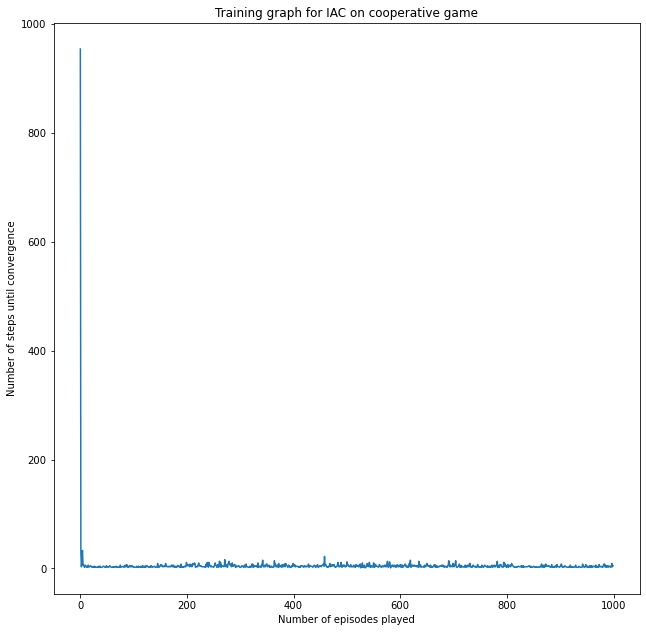

In [17]:
b = np.mean(steps_to_complete, axis=0)
print(steps_to_complete)
plt.xlabel('Number of episodes played')
plt.ylabel('Number of steps until convergence')
plt.title('Training graph for IAC on cooperative game')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)